<a href="https://colab.research.google.com/github/priyankaborwanker/Flood-Detection-Using-CNNs/blob/main/Ensemble_Model_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import cv2
import os
import math
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import models
from torchvision import transforms
import torch.optim as optim
import time
from PIL import Image
import pandas as pd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Images are stored in dataset folder
data_dir =  "/content/drive/MyDrive/NFT DATASET/Train"
dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((225)),transforms.RandomResizedCrop(224),transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]))
print(len(dataset))

611


In [ ]:
# Sizes of all the sets
train_size = 487
val_size = 62
test_size= 62
batch_size = 50

In [ ]:
#Splitting and Loading the sets
train_data,val_data,test_data = random_split(dataset,[train_size,val_size,test_size])
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size=16, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_data, batch_size=16, num_workers = 2, pin_memory = True)

In [ ]:
def ensemble_selector(loss_function, y_hats, y_true, init_size=1,
                      replacement=True, max_iter=100):
    """Implementation of the algorithm of Caruana et al. (2004) 'Ensemble
    Selection from Libraries of Models'. Given a loss function mapping
    predicted and ground truth values to a scalar along with a dictionary of
    models with predicted and ground truth values, constructs an optimal
    ensemble minimizing ensemble loss, by default allowing models to appear
    several times in the ensemble.

    Parameters
    ----------
    loss_function: function
        accepting two arguments - numpy arrays of predictions and true values - 
        and returning a scalar
    y_hats: dict
        with keys being model names and values being numpy arrays of predicted
        values
    y_true: np.array
        numpy array of true values, same for each model
    init_size: int
        number of models in the initial ensemble, picked by the best loss.
        Default is 1
    replacement: bool
        whether the models should be returned back to the pool of models once
        added to the ensemble. Default is True
    max_iter: int
        number of iterations for selection with replacement to perform. Only
        relevant if 'replacement' is True, otherwise iterations continue until
        the dataset is exhausted i.e.
        min(len(y_hats.keys())-init_size, max_iter). Default is 100

    Returns
    -------
    ensemble_loss: pd.Series
        with loss of the ensemble over iterations
    model_weights: pd.DataFrame
        with model names across columns and ensemble selection iterations
        across rows. Each value is the weight of a model in the ensemble
"""
  # Step 1: compute losses
    losses = dict()
    for model, y_hat in y_hats.items():
        losses[model] = loss_function(y_hat, y_true)

    # Get the initial ensemble comprised of the best models
    losses = pd.Series(losses).sort_values()
    init_ensemble = losses.iloc[:init_size].index.tolist()

    # Compute its loss
    if init_size == 1:
        # Take the best loss
        init_loss = losses.loc[init_ensemble].values[0]
        y_hat_avg = y_hats[init_ensemble[0]].copy()
    else:
        # Average the predictions over several models
        y_hat_avg = np.array(
            [y_hats[mod] for mod in init_ensemble]).mean(axis=0)
        init_loss = loss_function(y_hat_avg, y_true)

    # Define the set of available models
    if replacement:
        available_models = list(y_hats.keys())
    else:
        available_models = losses.index.difference(init_ensemble).tolist()
        # Redefine maximum number of iterations
        max_iter = min(len(available_models), max_iter)

    # Sift through the available models keeping track of the ensemble loss
    # Redefine variables for the clarity of exposition
    current_loss = init_loss
    current_size = init_size
    loss_progress = [current_loss]
    ensemble_members = [init_ensemble]
    for i in range(max_iter):
        # Compute weights for predictions
        w_current = current_size / (current_size + 1)
        w_new = 1 / (current_size + 1)

        # Try all models one by one
        tmp_losses = dict()
        tmp_y_avg = dict()
        for mod in available_models:
            tmp_y_avg[mod] = w_current * y_hat_avg + w_new * y_hats[mod]
            tmp_losses[mod] = loss_function(tmp_y_avg[mod], y_true)

        # Locate the best trial
        best_model = pd.Series(tmp_losses).sort_values().index[0]

        # Update the loop variables and record progress
        current_loss = tmp_losses[best_model]
        loss_progress.append(current_loss)
        y_hat_avg = tmp_y_avg[best_model]
        current_size += 1
        ensemble_members.append(ensemble_members[-1] + [best_model])

        if not replacement:
            available_models.remove(best_model)

    # Organize the output
    ensemble_loss = pd.Series(loss_progress, name="loss")
    model_weights = pd.DataFrame(index=ensemble_loss.index,
                                 columns=y_hats.keys())
    for ix, row in model_weights.iterrows():
        weights = pd.Series(ensemble_members[ix]).value_counts()
        weights = weights / weights.sum()
        model_weights.loc[ix, weights.index] = weights

    return ensemble_loss, model_weights.fillna(0).astype(float)

In [ ]:
def cross_entropy(predictions, targets, epsilon=1e-8):
    """Compute cross entropy given predictions as class probabilities and one-
    hot encoded ground truth labels.
    Parameters
    ----------
    predictions: np.array
        (num examples, num_classes) of predicted class probabilities
    targets: np.array
        (num examples, num_classes) of one-hot encoded true class labels
    epsilon: float
     a constant to clip predicted probabilities to avoid taking log of zero
    Returns
    -------
    cross_entropy: float
        cross entropy of the inputs
    """
    predictions = np.clip(predictions, epsilon, 1-epsilon)
    return (-np.log(predictions) * targets).sum(axis=1).mean()


def accuracy(predictions, targets, one_hot_targets=True):
    """Compute accuracy given arrays of predictions and targets.

    Parameters
    predictions: np.array
        (num examples, num_classes) of predicted class probabilities/scores
    targets: np.array
        (num examples, num_classes) of one hot encoded true class labels if
        'one_hot_targets' is True, or true class indices if it is False
    one_hot_targets: bool
        whether the target are in one-hot or class index format. Default is
        True

    Returns
    -------
    accuracy: float
        accuracy of predictions

    """
    if one_hot_targets:
        return (predictions.argmax(axis=1) == targets.argmax(axis=1)).mean()
    else:
        return (predictions.argmax(axis=1) == targets).mean()

In [ ]:
class MNISTMLP(nn.Module):
    """A simple MLP for MNIST.

    Class Attributes
    ----------------
    n_classes: int
        number of classes, corresponds to dimensionality of the output layer

    """
    n_classes = 2

    def __init__(self, d_in, n_layers, units, dropout, activation=nn.ReLU):
        """Instantiate.

        Parameters
        ----------
        d_in: int
            dimension of input vector
        n_layers: int
            number of hidden layers
        units: iterable
            of length equal number of layers with elements being integers
            specifying number of units in each layer
        dropout: float or None
            dropout probability, if None, no dropout is applied
        activation: torch.nn.modules.activation
            hidden layer activation function: 'nn.ReLU', 'nn.GELU', etc.
            Default is 'nn.ReLU'

        """
        super().__init__()
         # Check if units and layers match
        assert len(units) == n_layers

        # Assign parameters as attributes
        self.d_in = d_in
        self.n_layers = n_layers
        self.units = units
        self.activation = activation

        # Dropout operation
        if dropout is None:
            self.dropout = None
        else:
            self.dropout = nn.Dropout(p=dropout)

        # Construct intermediate layers
        if dropout is None:
            layers = [nn.Linear(d_in, units[0]), self.activation()]
            if n_layers > 1:
                for i, u in enumerate(units):
                    if i > 0:
                        layers.extend([nn.Linear(units[i-1], units[i]),
                                       self.activation()])
        else:
            layers = [nn.Linear(d_in, units[0]), self.activation(),
                      self.dropout]
            if n_layers > 1:
                for i, u in enumerate(units):
                    if i > 0:
                        layers.extend([nn.Linear(units[i-1], units[i]),
                                       self.activation(), self.dropout])

        # Final layer: outputs - raw scores
        self.final_layer = [nn.Linear(units[-1], self.n_classes)]
        layers.extend(self.final_layer)

        self.layers = nn.Sequential(*layers)
  
    def forward(self, x):
        """Forward pass."""
        flattened_x = x.view(-1, self.d_in)
        return self.layers(flattened_x)

In [ ]:
models_to_train = 5  # train this many models
max_epochs = 3        # for this many epochs
val_spilt = 0.25      # % of the torch MNIST train set for validation

# Define model names 
model_names = ["M" + str(m) for m in range(models_to_train)]

# Hyperparameters defining network architecture and training
n_layers = 3 
units = [100, 100, 100]
batch_size = 32
learning_rate = 1e-3
dropout = None

In [ ]:
# Since both validation and test use full batch, fetch the features and
# targets as tensors
for batch in val_dl:
    x_val, y_val = batch[0], batch[1]
for batch in test_dl:
    x_test, y_test = batch[0], batch[1]

In [ ]:

# Loss function is negative log-likelihood/cross-entropy
loss_fn = nn.CrossEntropyLoss()

# Train a pool of ensemble candidates
for model_name in model_names:

    # Define the model
    mlp = MNISTMLP(d_in=train_data[0][0].reshape(-1).shape[0],
                   n_layers=n_layers, units=units, dropout=None)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(max_epochs):

        # Training loop
        mlp.train()
        epoch_loss = []
        epoch_acc = []
        for x_batch, y_true_batch in train_dl:
            # Forward pass
            y_hat = mlp(x_batch)

            # Compute loss
            loss = loss_fn(y_hat, y_true_batch)

            # Backpropagate and update the weights
            loss.backward()
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()

            # Append loss and accuracy estimates
            epoch_loss.append(loss.item())
            epoch_acc.extend(
                (y_hat.argmax(dim=1) == y_true_batch)
                .detach().numpy().tolist()
                )
        # Compute metrics for this epoch
        train_loss.append(np.array(epoch_loss).mean())
        train_acc.append(np.array(epoch_acc).mean())

        # Process validation set
        mlp.eval()
        y_hat = mlp(x_val)
        loss = loss_fn(y_hat, y_val)
        val_loss.append(loss.item())
        val_acc.append(
            (y_hat.argmax(dim=1) == y_val).float().mean().item()
            )

        print(
            "Model Name {}, Epoch {}:\n"
            "Train Loss: {:4.4f}, Train Acc: {:4.4f} "
            "Val Loss: {:4.4f}, Val Acc: {:4.4f}".format(
                model_name, epoch,
                train_loss[-1], train_acc[-1],
                val_loss[-1], val_acc[-1])
            )

        # Save the checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": mlp.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": pd.DataFrame(
                {"train_loss": train_loss, "train_acc": train_acc,
                 "val_loss": val_loss, "val_acc": val_acc}).astype(float),
            "train_loss": train_loss[-1],
            "train_acc": train_acc[-1],
            "val_loss": val_loss[-1],
            "val_acc": val_acc[-1]
            },
            data_dir + model_name + "_epoch_" + str(epoch) + ".p")

Model Name M0, Epoch 0:
Train Loss: 1.7182, Train Acc: 0.5852 Val Loss: 0.6135, Val Acc: 0.6429
Model Name M0, Epoch 1:
Train Loss: 1.2142, Train Acc: 0.6632 Val Loss: 0.9128, Val Acc: 0.5714
Model Name M0, Epoch 2:
Train Loss: 1.3331, Train Acc: 0.7084 Val Loss: 0.7578, Val Acc: 0.7143
Model Name M1, Epoch 0:
Train Loss: 1.6469, Train Acc: 0.6304 Val Loss: 0.9661, Val Acc: 0.5714
Model Name M1, Epoch 1:
Train Loss: 1.8077, Train Acc: 0.6653 Val Loss: 0.7266, Val Acc: 0.6429
Model Name M1, Epoch 2:
Train Loss: 0.8746, Train Acc: 0.7474 Val Loss: 0.6684, Val Acc: 0.7143
Model Name M2, Epoch 0:
Train Loss: 1.7552, Train Acc: 0.6304 Val Loss: 1.4159, Val Acc: 0.7857
Model Name M2, Epoch 1:
Train Loss: 1.1322, Train Acc: 0.6735 Val Loss: 0.2959, Val Acc: 0.8571
Model Name M2, Epoch 2:
Train Loss: 1.0536, Train Acc: 0.7125 Val Loss: 0.5421, Val Acc: 0.7857
Model Name M3, Epoch 0:
Train Loss: 1.7351, Train Acc: 0.5975 Val Loss: 0.4525, Val Acc: 0.8571
Model Name M3, Epoch 1:
Train Loss: 1.12

In [ ]:
os.listdir(data_dir)[:2]

['Non Flooded', 'Flooded']

In [ ]:
# For each model pick the checkpoint with the lowest validation loss, then:
# 1. compute losses and accuracies on the validation and test set
# 2. get predictions on the validation set
trained_models = {}
metrics = {}
y_hats_val = {}
y_hats_test = {}
for model_name in model_names:
    # Load the last checkpoint
    last_checkpoint = torch.load(
        data_dir + model_name + "_epoch_" + str(max_epochs-1) + ".p")

    # Find the best checkpoint by validation loss
    best_by_val_loss = \
        last_checkpoint["history"].sort_values("val_loss").index[0]
    best_checkpoint = torch.load(
        data_dir + model_name + "_epoch_" +
        str(best_by_val_loss) + ".p"
        )

    # Restore the best checkpoint
    mlp = MNISTMLP(d_in=train_data[0][0].reshape(-1).shape[0],
                   n_layers=n_layers, units=units, dropout=dropout)
    mlp.load_state_dict(best_checkpoint["model_state_dict"])
    mlp.eval()

    # Compute predictions on the validation and test sets, compute the
    # metrics for the latter (validation stuff has already been saved)
    y_hat_val = mlp(x_val)
    y_hat_test = mlp(x_test)

    test_loss = loss_fn(y_hat_test, y_test).item()
    test_acc = (y_hat_test.argmax(dim=1) == y_test).float().mean().item()

    # Store the outputs
    trained_models[model_name] = mlp
    metrics[model_name] = {
        "val_loss": best_checkpoint["val_loss"],
        "val_acc": best_checkpoint["val_acc"],
        "test_loss": test_loss,
        "test_acc": test_acc
        }
    # Convert predictions to class probabilities
    y_hats_val[model_name] = y_hat_val.softmax(dim=1).detach().numpy()
    y_hats_test[model_name] = y_hat_test.softmax(dim=1).detach().numpy()

# Convert the metrics dict to a dataframe
metrics = pd.DataFrame(metrics).T.astype(float)

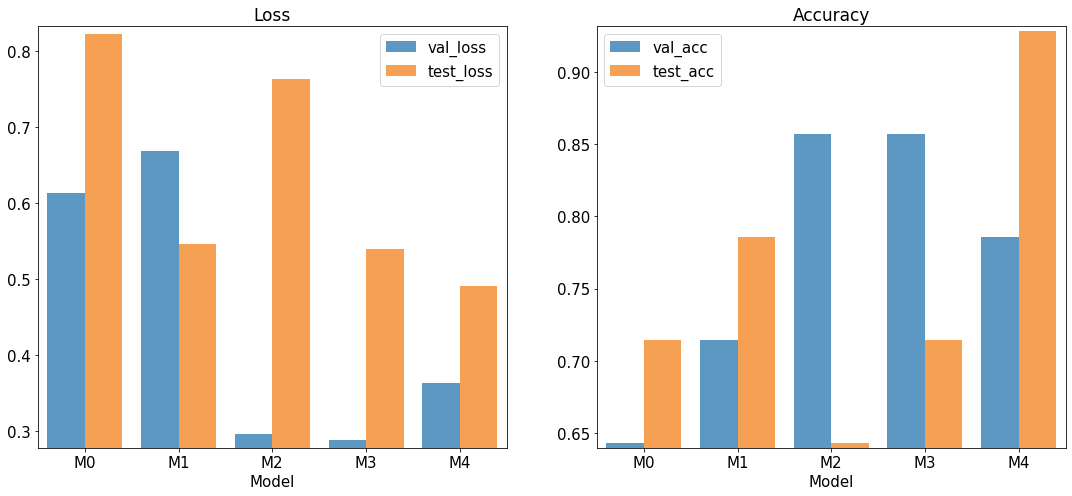

In [ ]:
# Separate dataframes for losses and accuracies
metrics_loss = metrics.filter(like="loss").stack().reset_index()
metrics_loss.columns = ["model", "val/test", "loss"]

metrics_acc = metrics.filter(like="acc").stack().reset_index()
metrics_acc.columns = ["model", "val/test", "acc"]

# Plot losses and accuracies
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.barplot(x="model", y="loss", hue="val/test", data=metrics_loss,
            alpha=0.75, saturation=0.90, palette=["#1f77b4", "#ff7f0e"],
            ax=ax[0])
sns.barplot(x="model", y="acc", hue="val/test", data=metrics_acc,
            alpha=0.75, saturation=0.90, palette=["#1f77b4", "#ff7f0e"],
            ax=ax[1])

ax[0].set_ylim(metrics_loss["loss"].min() - 1e-2,
               metrics_loss["loss"].max() + 1e-2)
ax[1].set_ylim(metrics_acc["acc"].min()-3e-3,
               metrics_acc["acc"].max()+3e-3)

ax[0].set_title("Loss", fontsize=17)
ax[1].set_title("Accuracy", fontsize=17)

for x in ax:
    x.xaxis.set_tick_params(rotation=0, labelsize=15)
    x.yaxis.set_tick_params(rotation=0, labelsize=15)
    x.set_xlabel("Model", visible=True, fontsize=15)
    x.set_ylabel("", visible=False)

    handles, labels = x.get_legend_handles_labels()
    x.legend(handles=handles, labels=labels, fontsize=15)

fig.tight_layout(w_pad=5)

In [ ]:
# One-hot encoded validation labels
y_true_one_hot_val = np.eye(2)[y_val.numpy()]

ensemble_loss, model_weights = ensemble_selector(
    loss_function=cross_entropy, y_hats=y_hats_val,
    y_true=y_true_one_hot_val, init_size=1, replacement=True, max_iter=10
    )

In [ ]:
print(ensemble_loss)

0     0.287774
1     0.272583
2     0.273658
3     0.272583
4     0.272753
5     0.272583
6     0.272558
7     0.272583
8     0.272500
9     0.272583
10    0.272482
Name: loss, dtype: float64


In [ ]:
print(model_weights)

     M0   M1        M2        M3   M4
0   0.0  0.0  0.000000  1.000000  0.0
1   0.0  0.0  0.500000  0.500000  0.0
2   0.0  0.0  0.333333  0.666667  0.0
3   0.0  0.0  0.500000  0.500000  0.0
4   0.0  0.0  0.400000  0.600000  0.0
5   0.0  0.0  0.500000  0.500000  0.0
6   0.0  0.0  0.428571  0.571429  0.0
7   0.0  0.0  0.500000  0.500000  0.0
8   0.0  0.0  0.444444  0.555556  0.0
9   0.0  0.0  0.500000  0.500000  0.0
10  0.0  0.0  0.454545  0.545455  0.0


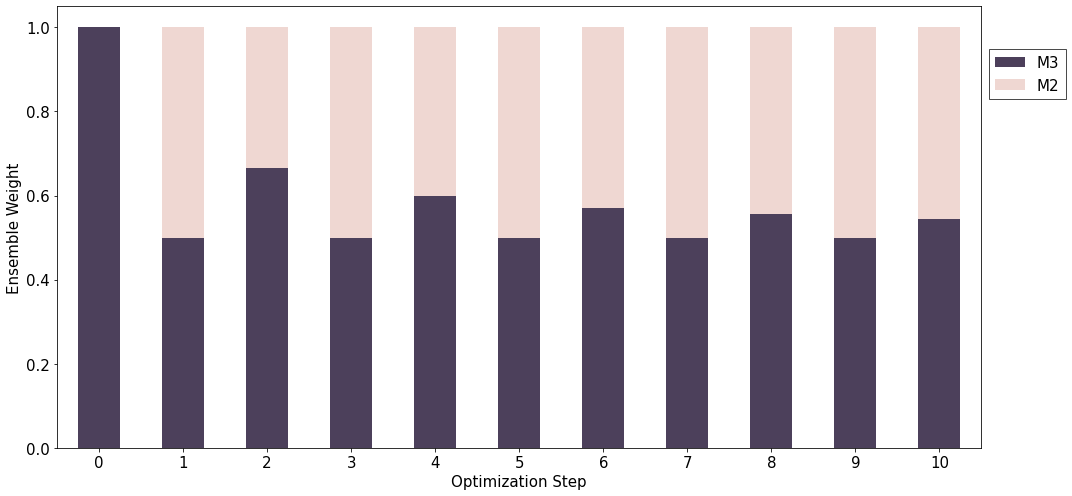

In [ ]:
# Locate non-zero weights and sort models by their average weight
weights_to_plot = model_weights.loc[:, (model_weights != 0).any()]
weights_to_plot = weights_to_plot[
    weights_to_plot.mean().sort_values(ascending=False).index]

# A palette corresponding to the number of models with non-zero weights
palette = sns.cubehelix_palette(weights_to_plot.shape[1], reverse=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
weights_to_plot.plot(kind="bar", stacked=True, color=palette, ax=ax,
                     alpha=0.85)

ax.margins(x=0.0)
ax.set_xlabel("Optimization Step", fontsize=15, visible=True)
ax.set_ylabel("Ensemble Weight", fontsize=15, visible=True)
ax.yaxis.set_tick_params(rotation=0, labelsize=15)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)
ax.legend(loc="best", bbox_to_anchor=(1, 0.92),
          frameon=True, edgecolor="k", fancybox=False,
          framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout()

In [ ]:
# Use the weights to construct the ensemble on the test set
y_true_one_hot_test = np.eye(2)[y_test.numpy()]

# Compute the test loss for each ensemble iteration
ensemble_loss_test = []
for _, row in model_weights.iterrows():
    # Compute test prediction for this iteration of ensemble weights
    tmp_y_hat = np.array(
        [y_hats_test[model_name] * weight
         for model_name, weight in row.items()]
        ).sum(axis=0)

    ensemble_loss_test.append(
        cross_entropy(tmp_y_hat, y_true_one_hot_test))
ensemble_loss_test = pd.Series(ensemble_loss_test)

In [ ]:
# Compute loss of an ensemble which equally weights each model in the pool
y_val_avg = np.array([_y for m, _y in y_hats_val.items()]).mean(axis=0)
ens_loss_val_avg = cross_entropy(y_val_avg, y_true_one_hot_val)

y_test_avg = np.array([_y for m, _y in y_hats_test.items()]).mean(axis=0)
ens_loss_test_avg = cross_entropy(y_test_avg, y_true_one_hot_test)

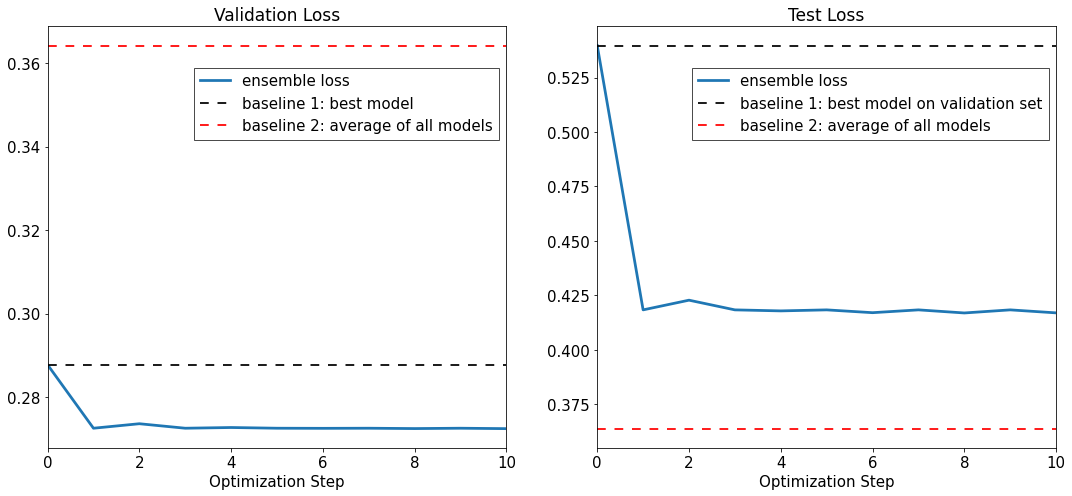

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=False)
ax[0].plot(ensemble_loss, color="#1f77b4", lw=2.75,
           label="ensemble loss")
ax[0].plot(pd.Series(ensemble_loss[0], ensemble_loss.index),
           color="k", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 1: best model")
ax[0].plot(pd.Series(ens_loss_val_avg, ensemble_loss.index),
           color="r", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 2: average of all models")

ax[1].plot(ensemble_loss_test, color="#1f77b4", lw=2.75,
           label="ensemble loss")
ax[1].plot(pd.Series(ensemble_loss_test[0], ensemble_loss_test.index),
           color="k", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 1: best model on validation set")
ax[1].plot(pd.Series(ens_loss_test_avg, ensemble_loss.index),
           color="r", lw=1.75, ls="--", dashes=(5, 5),
           label="baseline 2: average of all models")

ax[0].set_title("Validation Loss", fontsize=17)
ax[1].set_title("Test Loss", fontsize=17)

for x in ax:
    x.margins(x=0.0)
    x.set_xlabel("Optimization Step", fontsize=15, visible=True)
    x.set_ylabel("", fontsize=15, visible=False)
    x.yaxis.set_tick_params(labelsize=15)
    x.xaxis.set_tick_params(labelsize=15)
    x.legend(loc="upper right", bbox_to_anchor=(1, 0.92),
             frameon=True, edgecolor="k", fancybox=False,
             framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout(w_pad=3.14)

In [ ]:

# Accuracy-maximizing ensemble on the validation set
ensemble_acc, model_weights_acc = ensemble_selector(
    loss_function=lambda p, t: -accuracy(p, t),  # - for minimization
    y_hats=y_hats_val, y_true=y_true_one_hot_val,
    init_size=1, replacement=True, max_iter=10
    )
ensemble_acc = -ensemble_acc  # back to positive domain

# Compute accuracy of the equally weighted ensemble
ens_acc_val_avg = accuracy(y_val_avg, y_true_one_hot_val)

# Apply the weights to the predicitons on the test set
# Compute the test loss for each ensemble iteration
ensemble_acc_test = []
for _, row in model_weights_acc.iterrows():
    # Compute test prediction for this iteration of ensemble weights
    tmp_y_hat = np.array(
        [y_hats_test[model_name] * weight
         for model_name, weight in row.items()]
        ).sum(axis=0)

    ensemble_acc_test.append(
        accuracy(tmp_y_hat, y_true_one_hot_test))
ensemble_acc_test = pd.Series(ensemble_acc_test)

# Equally-weighted ensemble
ens_acc_test_avg = accuracy(y_test_avg, y_true_one_hot_test)

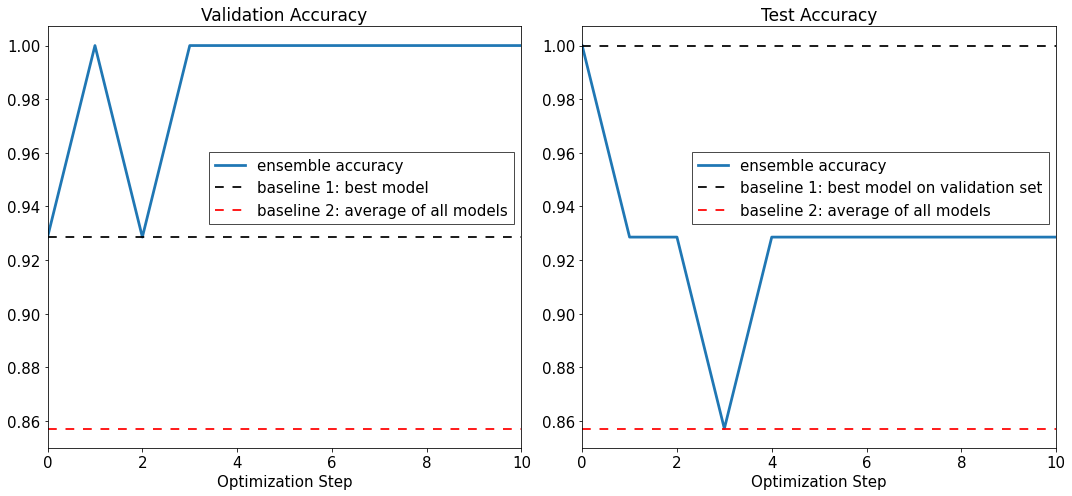

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=False)
ax[0].plot(ensemble_acc, color="#1f77b4", lw=2.75,label="ensemble accuracy")
ax[0].plot(pd.Series(ensemble_acc[0], ensemble_acc.index),
      color="k", lw=1.75, ls="--", dashes=(5, 5),
      label="baseline 1: best model")
ax[0].plot(pd.Series(ens_acc_val_avg, ensemble_loss.index),
      color="r", lw=1.75, ls="--", dashes=(5, 5),
      label="baseline 2: average of all models")

ax[1].plot(ensemble_acc_test, color="#1f77b4", lw=2.75,
      label="ensemble accuracy")
ax[1].plot(pd.Series(ensemble_acc_test[0], ensemble_loss_test.index),
      color="k", lw=1.75, ls="--", dashes=(5, 5),
      label="baseline 1: best model on validation set")
ax[1].plot(pd.Series(ens_acc_test_avg, ensemble_loss.index),
      color="r", lw=1.75, ls="--", dashes=(5, 5),
      label="baseline 2: average of all models")

ax[0].set_title("Validation Accuracy", fontsize=17)
ax[1].set_title("Test Accuracy", fontsize=17)

for x in ax:
   x.margins(x=0.0)
   x.set_xlabel("Optimization Step", fontsize=15, visible=True)
   x.set_ylabel("", fontsize=15, visible=False)
   x.yaxis.set_tick_params(labelsize=15)
   x.xaxis.set_tick_params(labelsize=15)
   x.legend(loc="upper right", bbox_to_anchor=(1, 0.72),
            frameon=True, edgecolor="k", fancybox=False,
            framealpha=0.7, shadow=False, ncol=1, fontsize=15)
   fig.tight_layout()